In [2]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import random
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-07-12 08:43:28.950698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752309809.299312      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752309809.395765      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
base_path = '/kaggle/input/teeth-dataset1'

print("Inside:", base_path)
first_level = os.listdir(base_path)
print(first_level)

# Go deeper into each folder under 'Teeth_Dataset'
for folder in first_level:
    full_path = os.path.join(base_path, folder)
    print(f"\nInside: {full_path}")
    second_level = os.listdir(full_path)
    print(second_level)
    print()

    # Now list each class folder and count files
    for subfolder in second_level:
        sub_path = os.path.join(full_path, subfolder)
        files = os.listdir(sub_path)
        print(f"  → {subfolder} contains {files} ")

Inside: /kaggle/input/teeth-dataset1
['Teeth_Dataset']

Inside: /kaggle/input/teeth-dataset1/Teeth_Dataset
['Validation', 'Training', 'Testing']

  → Validation contains ['OC', 'CaS', 'OT', 'CoS', 'Gum', 'MC', 'OLP'] 
  → Training contains ['OC', 'CaS', 'OT', 'CoS', 'Gum', 'MC', 'OLP'] 
  → Testing contains ['OC', 'outputs', 'output', 'CaS', 'out', 'OT', 'CoS', 'output_image.jpg', 'Gum', 'MC', 'OLP'] 


In [4]:
base_path = "/kaggle/input/teeth-dataset1/Teeth_Dataset"

train_data = tf.keras.utils.image_dataset_from_directory(
    base_path + "/Training",
    image_size=(224, 224),
    batch_size=32
)

val_data = tf.keras.utils.image_dataset_from_directory(
    base_path + "/Validation",
    image_size=(224, 224),
    batch_size=32
)

test_data = tf.keras.utils.image_dataset_from_directory(
    base_path + "/Testing",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 3087 files belonging to 7 classes.


I0000 00:00:1752309833.980468      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752309833.981146      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1028 files belonging to 7 classes.
Found 1508 files belonging to 10 classes.


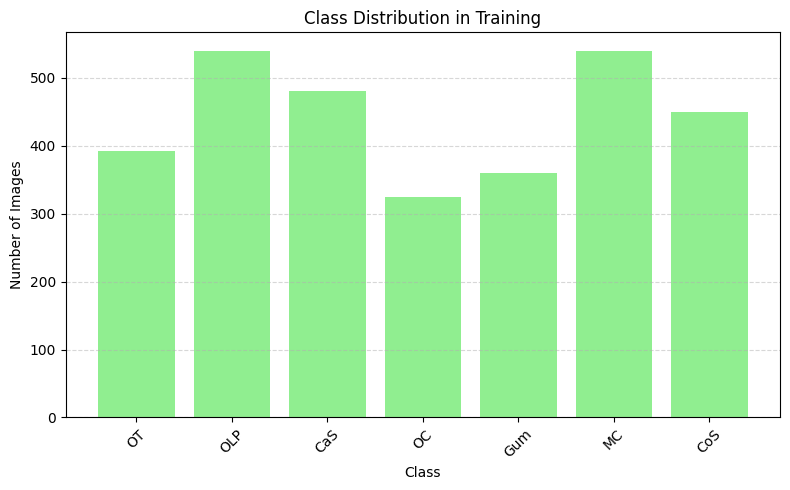

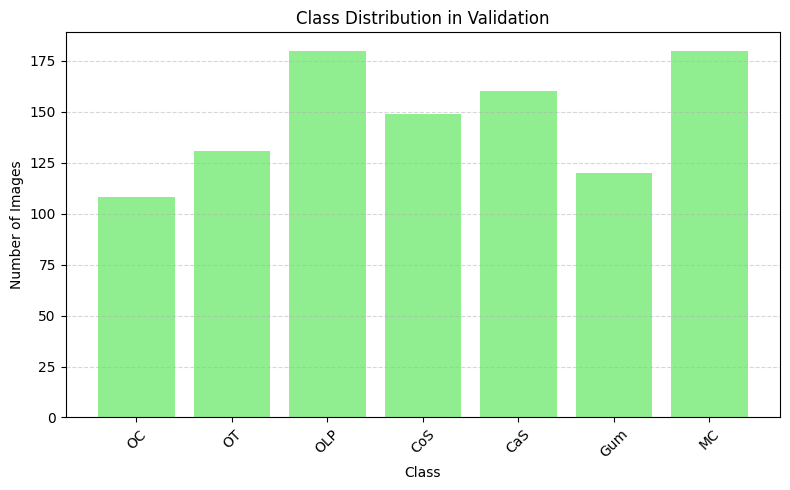

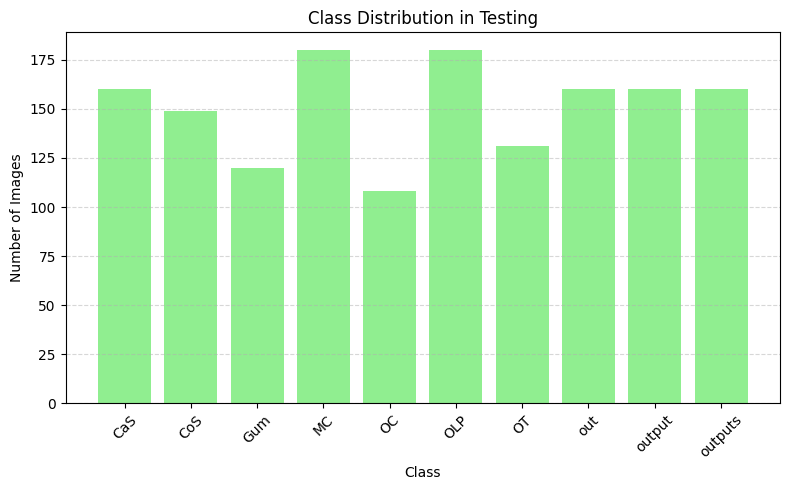

In [5]:
from collections import Counter

def plot_class_distribution(dataset, dataset_name):
    
    class_names = dataset.class_names

    
    
    class_counts = Counter()
    for images, labels in dataset:
        label_vals = labels.numpy()
        for label in label_vals:
            class_counts[class_names[label]] += 1


    labels = list(class_counts.keys())
    counts = list(class_counts.values())

   
    plt.figure(figsize=(8, 5))
    plt.bar(labels, counts, color='lightgreen')
    plt.title(f'Class Distribution in {dataset_name}')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


plot_class_distribution(train_data, 'Training')
plot_class_distribution(val_data, 'Validation')
plot_class_distribution(test_data, 'Testing')

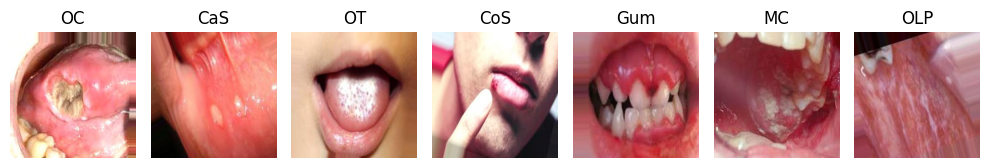

<Figure size 640x480 with 0 Axes>

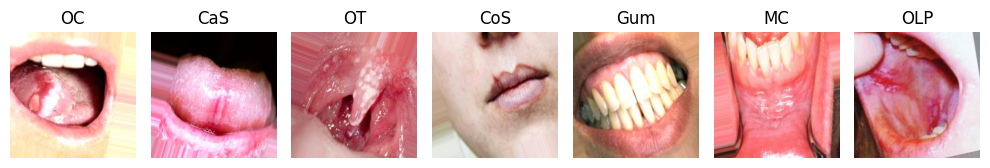

<Figure size 640x480 with 0 Axes>

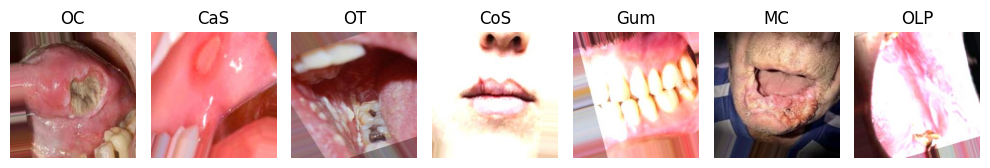

Text(0.5, 1.0, 'Random Images [Test Dataset]:')

<Figure size 640x480 with 0 Axes>

In [6]:
Illness = ['OC', 'CaS', 'OT', 'CoS', 'Gum', 'MC', 'OLP']
Types = ['Validation', 'Training', 'Testing']
def plot_one_image_per_illness(category, illness_list):

    fig, axes = plt.subplots(1, len(illness_list), figsize=(10, 10))
    if len(illness_list) == 1:
        axes = [axes]

    for ax, illness in zip(axes, illness_list):
        # illness_dir = "/kaggle/input/teeth-dataset/Teeth_Dataset/OC"
        illness_dir = os.path.join(base_path, category, illness)
        valid_extensions = ('.jpeg', '.jpg', '.bmp', '.png')
        #illness_image = list of the path of each image 
        illness_images = list(filter(lambda x: x.endswith(valid_extensions), os.listdir(illness_dir)))

        if illness_images:
            img_path = os.path.join(illness_dir, random.choice(illness_images))
            img = plt.imread(img_path)
            ax.imshow(img)
            ax.set_title(illness)
            ax.axis('off')
        else:
            ax.set_title(f'No images for {illness}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()


plot_one_image_per_illness(Types[0], Illness)
plt.suptitle('Random Images [Validation Dataset]:', y=1.00)

plot_one_image_per_illness(Types[1], Illness)
plt.suptitle('Random Images [Training Dataset]:', y=1.00)

plot_one_image_per_illness(Types[2], Illness)
plt.suptitle('Random Images [Test Dataset]:', y=1.00)

## ResNet 

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D

In [8]:
from tensorflow.keras.applications.resnet50 import preprocess_input
def Load_and_preprocessing(train_data, validation_data, target_size, batch_size):
    train_datagen = ImageDataGenerator(
       preprocessing_function=preprocess_input,
        # rotation_range=20,
        # width_shift_range=0.2,
        # height_shift_range = 0.2,
        # shear_range= 0.2,
        # zoom_range=0.2,
        #  horizontal_flip=True,
        # fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator = train_datagen.flow_from_directory(
        train_data,
        target_size =  target_size,
        batch_size=batch_size,
        class_mode = 'categorical'
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_data,
        target_size= target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )


    return train_generator, validation_generator


In [9]:
train_generator, validation_generator = Load_and_preprocessing('/kaggle/input/teeth-dataset1/Teeth_Dataset/Training',
                                                               '/kaggle/input/teeth-dataset1/Teeth_Dataset/Validation',
                                                               target_size=(224, 224),
                                                                batch_size=32)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
from tensorflow.keras.layers import BatchNormalization

x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(7, activation='softmax')(x)
ResNet_model = Model(inputs= base_model.input, outputs=output)

In [13]:
ResNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
history = ResNet_model.fit(
    train_generator,
    epochs=30,
    validation_data = validation_generator,
    # callbacks=[ reduce_lr]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1752309991.329481     107 service.cc:148] XLA service 0x7bc1900530f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752309991.331026     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752309991.331053     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752309992.988977     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/97 ━━━━━━━━━━━━━━━━━━━━ 30:31 19s/step - accuracy: 0.2812 - loss: 2.5321

I0000 00:00:1752309999.248480     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 252ms/step - accuracy: 0.4500 - loss: 1.5312 - val_accuracy: 0.8123 - val_loss: 0.6040
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.7739 - loss: 0.6174 - val_accuracy: 0.9212 - val_loss: 0.3106
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.8710 - loss: 0.3623 - val_accuracy: 0.9523 - val_loss: 0.1829
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9212 - loss: 0.2593 - val_accuracy: 0.9698 - val_loss: 0.1244
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.9271 - loss: 0.1933 - val_accuracy: 0.9679 - val_loss: 0.1115
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.9543 - loss: 0.1356 - val_accuracy: 0.9708 - val_loss: 0.0825
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.9652 - loss: 0.1041 - val_accuracy: 0.9660 - val_loss: 0.0925
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.9654 - loss: 0.1017 - val_accuracy: 0.971

In [15]:
for layer in ResNet_model.layers[-30:]:
    layer.trainable = True

In [ ]:
ResNet_model.compile(optimizer=Adam(learning_rate=1e-5),  # Smaller LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_resnet_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

# Train with callbacks
history = ResNet_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9890 - loss: 0.0329
Epoch 1: val_accuracy improved from -inf to 0.97860, saving model to best_resnet_model.h5
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.9890 - loss: 0.0330 - val_accuracy: 0.9786 - val_loss: 0.0579 - learning_rate: 0.0010
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9801 - loss: 0.0701
Epoch 2: val_accuracy improved from 0.97860 to 0.98541, saving model to best_resnet_model.h5
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.9802 - loss: 0.0699 - val_accuracy: 0.9854 - val_loss: 0.0506 - learning_rate: 0.0010
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9883 - loss: 0.0453
Epoch 3: val_accuracy improved from 0.98541 to 0.98638, saving model to best_resnet_model.h5
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9883 - loss: 0.0453 - val_accuracy: 0.9864 - val_loss: 0.0325 - learning_rate: 0.0010
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 9

In [18]:
from tensorflow.keras.models import load_model
best_model = load_model('best_resnet_model.h5')

In [20]:
import shutil
import os

# Copy entire dataset to a writable directory
src = '/kaggle/input/teeth-dataset1/Teeth_Dataset'
dst = '/kaggle/working/teeth-dataset1/Teeth_Dataset'
shutil.copytree(src, dst)

'/kaggle/working/teeth-dataset1/Teeth_Dataset'

In [22]:
# Now you can delete, move, or modify files in the working directory
shutil.rmtree('/kaggle/working/teeth-dataset1/Teeth_Dataset/Testing/out')

In [23]:
shutil.rmtree('/kaggle/working/teeth-dataset1/Teeth_Dataset/Testing/outputs')

In [24]:
shutil.rmtree('/kaggle/working/teeth-dataset1/Teeth_Dataset/Testing/output')

In [37]:
test_data = '/kaggle/working/teeth-dataset1/Teeth_Dataset/Testing'
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 1028 images belonging to 7 classes.


In [38]:
test_loss, test_accuracy = ResNet_model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9814 - loss: 0.0410 
Test Loss: 0.045991893857717514
Test Accuracy: 0.9824903011322021


In [39]:
from sklearn.metrics import classification_report


# Step 1: Make predictions
predictions = ResNet_model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Step 2: Get the true labels
y_true = test_generator.classes

# Step 3: Get class labels (names)
class_labels = list(test_generator.class_indices.keys())

# Step 4: Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step
              precision    recall  f1-score   support

         CaS       0.99      0.97      0.98       160
         CoS       1.00      1.00      1.00       149
         Gum       0.99      0.98      0.99       120
          MC       0.95      0.99      0.97       180
          OC       0.98      0.95      0.97       108
         OLP       0.98      0.97      0.97       180
          OT       0.99      1.00      1.00       131

    accuracy                           0.98      1028
   macro avg       0.98      0.98      0.98      1028
weighted avg       0.98      0.98      0.98      1028



33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step


<Figure size 800x600 with 0 Axes>

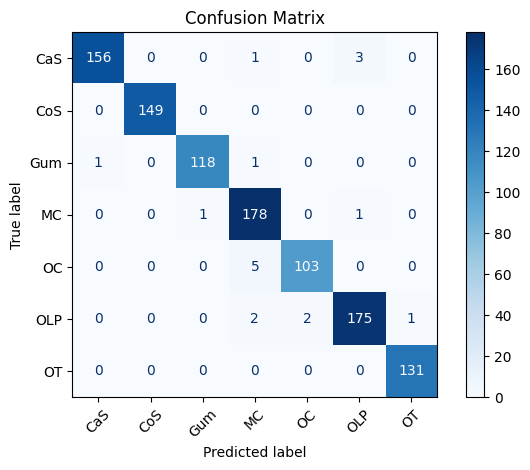

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


true_labels = test_generator.classes
predictions = ResNet_model.predict(test_generator)


predicted_labels = np.argmax(predictions, axis=1)
class_names = list(test_generator.class_indices.keys())


cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


## Efficent net 

In [53]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [43]:
def Load_and_preprocessing(train_data, validation_data, target_size, batch_size):
    train_datagen = ImageDataGenerator(
       preprocessing_function=preprocess_input,
        # rotation_range=20,
        # width_shift_range=0.2,
        # height_shift_range = 0.2,
        # shear_range= 0.2,
        # zoom_range=0.2,
        #  horizontal_flip=True,
        # fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator = train_datagen.flow_from_directory(
        train_data,
        target_size =  target_size,
        batch_size=batch_size,
        class_mode = 'categorical'
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_data,
        target_size= target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )


    return train_generator, validation_generator


In [44]:
train_generator, validation_generator = Load_and_preprocessing('/kaggle/input/teeth-dataset1/Teeth_Dataset/Training',
                                                               '/kaggle/input/teeth-dataset1/Teeth_Dataset/Validation',
                                                               target_size=(224, 224),
                                                                batch_size=32)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [45]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [54]:
for layer in base_model.layers:
    layer.trainable = False

In [55]:
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(7, activation='softmax')(x)

In [56]:
efficinet_model = Model(inputs=base_model.input, outputs=output)

In [57]:
efficinet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
history = efficinet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
)

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 283ms/step - accuracy: 0.4749 - loss: 1.4850 - val_accuracy: 0.8580 - val_loss: 0.7307
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.8067 - loss: 0.5597 - val_accuracy: 0.9280 - val_loss: 0.3355
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8805 - loss: 0.3454 - val_accuracy: 0.9630 - val_loss: 0.1659
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9105 - loss: 0.2645 - val_accuracy: 0.9718 - val_loss: 0.1128
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9300 - loss: 0.2099 - val_accuracy: 0.9728 - val_loss: 0.0820
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9369 - loss: 0.1909 - val_accuracy: 0.9728 - val_loss: 0.0771
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9434 - loss: 0.1708 - val_accuracy: 0.9767 - val_loss: 0.0737
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9492 - loss: 0.1392 - val_accuracy: 0.9805 -

In [60]:
for layer in ResNet_model.layers[-20:]:
    layer.trainable = True

In [61]:
efficinet_model.compile(optimizer=Adam(learning_rate=1e-5),  # Smaller LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [64]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_efficientnet_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
]


history = efficinet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9795 - loss: 0.0625
Epoch 1: val_accuracy improved from -inf to 0.98833, saving model to best_efficientnet_model.h5
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9795 - loss: 0.0625 - val_accuracy: 0.9883 - val_loss: 0.0301 - learning_rate: 6.2500e-07
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9845 - loss: 0.0505
Epoch 2: val_accuracy did not improve from 0.98833
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9844 - loss: 0.0506 - val_accuracy: 0.9883 - val_loss: 0.0301 - learning_rate: 6.2500e-07
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9825 - loss: 0.0545
Epoch 3: val_accuracy did not improve from 0.98833

Epoch 3: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9825 - loss: 0.0546 - val_accuracy: 0.9883 - val_loss: 0.0303 - learning_rate: 6.2500e-07
Epoch 4/20
96/97 ━━━━━━━━━━━━━━━━━━━━ 0

In [65]:
best_model2 = load_model('best_efficientnet_model.h5')

In [66]:
test_data = '/kaggle/working/teeth-dataset1/Teeth_Dataset/Testing'
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 1028 images belonging to 7 classes.


In [68]:
test_loss, test_accuracy = best_model2 .evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.9970 - loss: 0.0198
Test Loss: 0.028325233608484268
Test Accuracy: 0.994163453578949


In [69]:
from sklearn.metrics import classification_report


# Step 1: Make predictions
predictions = best_model2.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Step 2: Get the true labels
y_true = test_generator.classes

# Step 3: Get class labels (names)
class_labels = list(test_generator.class_indices.keys())

# Step 4: Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 222ms/step
              precision    recall  f1-score   support

         CaS       0.98      1.00      0.99       160
         CoS       1.00      1.00      1.00       149
         Gum       1.00      0.99      1.00       120
          MC       0.98      1.00      0.99       180
          OC       1.00      0.97      0.99       108
         OLP       1.00      0.99      0.99       180
          OT       1.00      1.00      1.00       131

    accuracy                           0.99      1028
   macro avg       1.00      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028



33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


<Figure size 800x600 with 0 Axes>

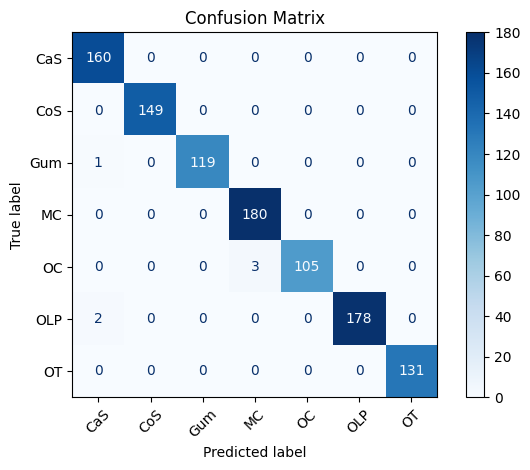

In [70]:
true_labels = test_generator.classes
predictions = best_model2.predict(test_generator)


predicted_labels = np.argmax(predictions, axis=1)
class_names = list(test_generator.class_indices.keys())


cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()
